<a href="https://colab.research.google.com/github/ulya1202/NLP/blob/main/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import

In [ ]:
import tensorflow as tf
import pandas as pd
import ast

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
!curl -L -o ner-dataset.zip  https://www.kaggle.com/api/v1/datasets/download/rohitr4307/ner-dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 4561k  100 4561k    0     0  8877k      0 --:--:-- --:--:-- --:--:-- 8877k


In [ ]:
!unzip /content/ner-dataset.zip

Archive:  /content/ner-dataset.zip
  inflating: NER_Dataset.csv         


# start

## Functions

In [ ]:
def len_of_rows(row):
    return len(ast.literal_eval(row))

def eval_row_and_join(row):
    return ' '.join(ast.literal_eval(row))

# def combine_sentences(sentences):
#     all_train=''.join([ sentence for sentence in sentences.apply(eval_row_and_join)])
#     return all_train

def vec_pad(data, name, pad=True,max_len=50, padding_type='post'):
    if isinstance(data, str):#chta gpt burda komek etdu bu setirde<----
        data = [data]
    if name=='pos':
        X=text_vec_pos(data)
    elif name=='words':
        X=text_vec_words(data)
    elif name=='tag':
        X=text_vec_tag(data)
    if pad:
        X=tf.keras.utils.pad_sequences(
                                        X,
                                        maxlen=max_len,
                                        dtype='int32',
                                        padding=padding_type,
                                        truncating=padding_type)
    return X

def for_testing(your_string_word, your_pos_string):

    your_string_words=tf.constant([your_string_word])
    X_test_words=vec_pad(your_string_words, 'words', max_len=max_len)
    X_test_pos=vec_pad(your_pos_string, 'pos', max_len=max_len)
    y_proba=model.predict((X_test_words,X_test_pos))
    idxs=np.argmax(y_proba, axis=-1).flatten()
    vocab=text_vec_tag.get_vocabulary()
    ans=''
    names=''

    for idx,i in enumerate(idxs):
        ans+=vocab[i]+' '
        if i==0:
            break

        if idx<len(your_string_word.split()):
            if vocab[i]!='o' and vocab[i].startswith('b'):
                names+='\nbegins '+vocab[i][1:]+f' at index: {idx} \n'+your_string_word.split()[idx]+' '
            elif idx>0 and vocab[idxs[idx-1]].startswith('i') and vocab[i].startswith('o') :
                names+='\nends '+vocab[idxs[idx-1]][1:]+f' at index: {idx} '
            elif vocab[i]!='o':
                names+=' '+ your_string_word.split()[idx]
    return print(f'{ans}\n {names}')


## EDA

In [ ]:
#elave bax explode--> ile Bio-nu tag for each ele

In [ ]:
nf=pd.read_csv('NER_Dataset.csv')

In [ ]:
df=nf.drop('Sentence_ID', axis=1)

In [ ]:
df.iloc[-1].apply(eval_row_and_join)['Word']

'The United Nations is praising the use of military helicopters to drop food and rescue survivors in tsunami-ravaged Indonesia , saying the aircraft are " worth their weight in gold . "'

In [ ]:
pos_1=df.iloc[-1].apply(eval_row_and_join)['POS']

In [ ]:
answers_1=df.iloc[-1].apply(eval_row_and_join)['Tag']

In [ ]:
train_p=int(len(df)*0.8)
val_p=train_p+int(len(df)*0.1)
test_p=len(df)

In [ ]:
train_data=df[:train_p]
val_data=df[train_p:val_p]
test_data=df[val_p:]

In [ ]:
train_words=train_data['Word']
train_POS=train_data['POS']

train_tag=train_data['Tag']

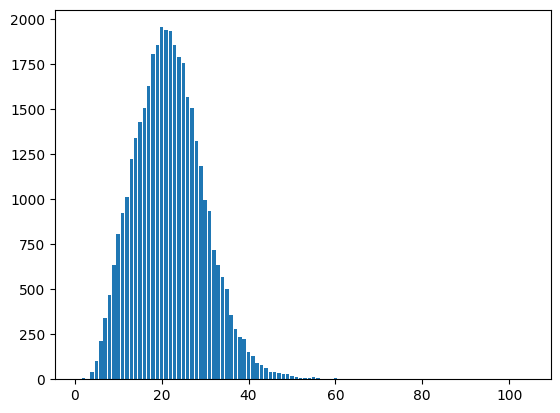

In [ ]:
count_of_words=train_words.apply(len_of_rows).value_counts()
plt.bar(x=count_of_words.index , height=count_of_words);

In [ ]:
max_len_of_words=max(train_words.apply(len_of_rows))
max_len_of_words

104

In [ ]:
max_len=int(np.percentile(train_words.apply(len_of_rows), q=99.9))

##Tokenization

In [ ]:
#cumller bizde string formatinda idi deye , bele bir funksiya yazdim ki'[jj,''']' bele bir formatda olani list kim iqebul etsin , ve ordaki sozleri birleshdirsin ,e ve daaset kimi yazsin
#neticede ['']-> '' her sutunda ., indi bizde pd .series oldu duzelmish shekilde onu men tensorlara bolurem ki rahat gonderim text vec-a ,
#tebii ki etmek de olardi bu zamn gerek list ederdim butun cumlelri birlsehdirerdim
train_words_joined = train_words.apply(eval_row_and_join).tolist()
train_pos_joined = train_POS.apply(eval_row_and_join).tolist()
train_tag_joined = train_tag.apply(eval_row_and_join).tolist()

In [ ]:
all_words_train=tf.data.Dataset.from_tensor_slices(train_words_joined).batch(1024).prefetch(tf.data.AUTOTUNE)
all_pos_train=tf.data.Dataset.from_tensor_slices(train_pos_joined).batch(1024).prefetch(tf.data.AUTOTUNE)
all_tag_train=tf.data.Dataset.from_tensor_slices(train_tag_joined).batch(1024).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Tokenization
text_vec_words=tf.keras.layers.TextVectorization(split="whitespace",
                                  output_mode="int",
                                  output_sequence_length=max_len
                                  )
text_vec_pos=tf.keras.layers.TextVectorization(split="whitespace",
                                  output_mode="int",
                                  output_sequence_length=max_len
                                  )
text_vec_tag=tf.keras.layers.TextVectorization(split="whitespace",
                                  output_mode="int",
                                  output_sequence_length=max_len
                                  )

text_vec_words.adapt(all_words_train)
text_vec_pos.adapt(all_pos_train)
text_vec_tag.adapt(all_tag_train)


In [ ]:
text_vec_words.vocabulary_size(),text_vec_tag.vocabulary_size(),text_vec_pos.vocabulary_size()

(28372, 19, 36)

In [ ]:
vocab_size_words=text_vec_words.vocabulary_size()
vocab_size_pos=text_vec_pos.vocabulary_size()
vocab_size_tag=text_vec_tag.vocabulary_size()


In [ ]:
X_train_words=vec_pad(train_words, 'words', max_len=max_len)
X_train_pos=vec_pad(train_POS, 'pos', max_len=max_len)
y_train_tag=vec_pad(train_tag, 'tag', max_len=max_len)

X_val_words=vec_pad(val_data['Word'], 'words', max_len=max_len)
X_val_pos=vec_pad(val_data['POS'], 'pos', max_len=max_len)
y_val_tag=vec_pad(val_data['Tag'], 'tag', max_len=max_len)

X_test_words=vec_pad(test_data['Word'], 'words', max_len=max_len)
X_test_pos=vec_pad(test_data['POS'], 'pos', max_len=max_len)
y_test_tag=vec_pad(test_data['Tag'], 'tag', max_len=max_len)


In [ ]:
embed_size=256
# Input
encoder_input_words=tf.keras.layers.Input(shape=(None,))
encoder_input_pos=tf.keras.layers.Input(shape=(None,))

# Embeding of words and POS
encoder_words_embedding_layer=tf.keras.layers.Embedding(input_dim=vocab_size_words,
                                            output_dim=embed_size,
                                            mask_zero=True
                                            )
encoder_POS_embedding_layer=tf.keras.layers.Embedding(input_dim=vocab_size_pos,
                                            output_dim=embed_size,
                                            mask_zero=True
                                            )

encoder_words_embedding=encoder_words_embedding_layer(encoder_input_words)
encoder_POS_embedding=encoder_POS_embedding_layer(encoder_input_pos)
encoder_words_POS_embedding=encoder_words_embedding+encoder_POS_embedding


#Positional embedding
encoder_positional_embedding_layer=tf.keras.layers.Embedding(input_dim=max_len,
                                                            output_dim=embed_size)
encoder_positions=tf.keras.layers.Lambda(lambda x: tf.range(start=0, limit=x.shape[1], delta=1))(encoder_words_POS_embedding)

encoder_positional_embedding=encoder_positional_embedding_layer(encoder_positions)

encoder_full_embedding=encoder_positional_embedding+encoder_words_POS_embedding


In [ ]:
#Encoder Transformer
encoder_attentions=tf.keras.layers.MultiHeadAttention(num_heads=5, key_dim=embed_size)(encoder_full_embedding,encoder_full_embedding)

encoder_normlized=tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoder_attentions+encoder_full_embedding)
encoder_ff=tf.keras.layers.Dense(512,activation='relu', kernel_initializer='he_normal')(encoder_normlized)
encoder_output=tf.keras.layers.Dense(vocab_size_tag,activation='softmax')(encoder_ff)



In [ ]:
model=tf.keras.Model(inputs=(encoder_input_words,encoder_input_pos), outputs=encoder_output)

## Callbacks and learning scheduler

In [ ]:
model_ckp=tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/NER.keras',
                                   monitor='val_loss',
                                   save_best_only=True)
learnig_rate_scheduler=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1050,
    decay_rate=0.96,

    name='ExponentialDecay'
)
model_early_stop=tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
     restore_best_weights=True,

)
optimizer=tf.keras.optimizers.Nadam(learnig_rate_scheduler)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'] )

##Model compile and fit

In [ ]:
model.fit((X_train_words, X_train_pos), y_train_tag,validation_data=((X_val_words, X_val_pos),y_val_tag), epochs=100,callbacks=[model_early_stop,model_ckp] )

Epoch 1/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 38s 25ms/step - accuracy: 0.9119 - loss: 0.3297 - val_accuracy: 0.9449 - val_loss: 0.1911
Epoch 2/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9483 - loss: 0.1780 - val_accuracy: 0.9483 - val_loss: 0.1787
Epoch 3/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9534 - loss: 0.1581 - val_accuracy: 0.9450 - val_loss: 0.1821
Epoch 4/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9561 - loss: 0.1466 - val_accuracy: 0.9477 - val_loss: 0.1754
Epoch 5/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.9585 - loss: 0.1363 - val_accuracy: 0.9485 - val_loss: 0.1746
Epoch 6/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 17s 14ms/step - accuracy: 0.9608 - loss: 0.1282 - val_accuracy: 0.9482 - val_loss: 0.1774
Epoch 7/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - accuracy: 0.9633 - loss: 0.1197 - val_accuracy: 0.9471 - val_loss: 0.1820
Epoch 8/100
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 

In [ ]:
for_testing('the man women is praising the use of Army Plains to drop HONEY-MMC and escper survivors in Rain-ravaged Baku , saying the aircraft are " worth their weight in SILVER ! ', pos_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
o borg iorg o o o o o o o o o o o o o o o bgeo o o o o o o o o o o o o  
 
begins org at index: 1 
man  women
ends org at index: 3 
begins geo at index: 18 
Baku 
